Discrete Sim of lost person dynamics

inputs:
- landscape: some array of coordinates, each cell with
    - elevation
    - amount of linear-feature-ness
- Person:
    - gets tired, store energy
    - profiles
        - random
        -


In [1]:
!pip install noise
!pip install rasterio

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2 # just for realistic elevation generation
import matplotlib.patches as mpatches
import cv2
import rasterio
np.random.seed(0)

In [3]:
class Agent:
    def __init__(self, start_position, profile=[1, 0, 0, 0, 0, 0]):
        self.position = np.array(start_position)
        self.energy = 100
        self.profile = profile
        self.history = [tuple(start_position)]
        self.velocity = np.random.randint(-1, 2, size=2)

    def random_walk(self, landscape):
        direction = np.random.randint(-1, 2, size=2)
        new_position = self.position + direction
        new_position = np.clip(new_position, 0, landscape.size - 1)
        self.position = new_position
        self.energy -= 1
        self.history.append(tuple(self.position))

    def route_travel(self, landscape):
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        for dx, dy in directions:
            nx, ny = self.position[0] + dx, self.position[1] + dy
            if 0 <= nx < landscape.size and 0 <= ny < landscape.size:
                if landscape.linear_features[nx, ny] == 1:
                    self.position = np.array([nx, ny])
                    self.energy -= 1
                    self.history.append(tuple(self.position))
                    return

    def direction_travel(self, landscape):
        new_position = self.position + self.velocity
        new_position = np.clip(new_position, 0, landscape.size - 1)
        self.position = new_position
        self.energy -= 1
        self.history.append(tuple(self.position))

    def stay_put(self, landscape):
        self.history.append(tuple(self.position))

    def view_enhance(self, landscape):
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        current_x, current_y = self.position
        current_elevation = landscape.elevation[current_x, current_y]
        best_position = self.position
        best_elevation = current_elevation
        for dx, dy in directions:
            nx, ny = current_x + dx, current_y + dy
            if 0 <= nx < landscape.size and 0 <= ny < landscape.size:
                elevation = landscape.elevation[nx, ny]
                if elevation > best_elevation:
                    best_position, best_elevation = [nx, ny], elevation
        self.position = np.array(best_position)
        self.energy -= 1
        self.history.append(tuple(self.position))

    def backtrack(self, landscape):
        if len(self.history) > 1:
            self.history.pop()
            new_position = self.history[-1]
            self.position = np.array(new_position)
            self.energy -= 1
            self.history.append(tuple(self.position))

    def reset(self):
        self.energy = 100
        self.history = [tuple(self.position)]


class Landscape:
    def __init__(self, size, rgb_image_path=None, depth_image_path=None):
        self.size = size
        if rgb_image_path and depth_image_path:
            rgb_image = self.load_rgb_image(rgb_image_path)
            depth_image = self.load_depth_image(depth_image_path)
            rgb_image_cropped = self.crop_center(rgb_image, 256, 256)
            depth_image_cropped = self.crop_center(depth_image, 256, 256)
            self.elevation = self.process_depth(depth_image_cropped)
            self.linear_features = self.detect_linear_features(self.elevation)
        else:
            self.elevation = self.generate_elevation()
            self.linear_features = self.generate_linear_features()

    def load_rgb_image(self, rgb_image_path):
        rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)
        if rgb_image is None or rgb_image.shape[2] != 3:
            raise ValueError("Invalid RGB image. Ensure the image is 3-channel (RGB).")
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        return rgb_image

    def load_depth_image(self, depth_image_path):
        with rasterio.open(depth_image_path) as dataset:
            depth_image = dataset.read(1).astype(np.float32)
        return depth_image

    def crop_center(self, img, cropx, cropy):
        y, x = img.shape[:2]
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return img[starty:starty+cropy, startx:startx+cropx]

    def process_depth(self, depth_image):
        depth_resized = cv2.resize(depth_image, (self.size, self.size))
        normalized_depth = (depth_resized - depth_resized.min()) / (depth_resized.max() - depth_resized.min())
        return normalized_depth

    def detect_linear_features(self, elevation):
        edges = cv2.Canny((elevation * 255).astype(np.uint8), 100, 200)
        linear_features = cv2.resize(edges, (self.size, self.size)).astype(np.float32) / 255
        return linear_features

    def generate_elevation(self):
        scale = 100.0
        octaves = 6
        persistence = 0.5
        lacunarity = 2.0
        elevation = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                elevation[i][j] = pnoise2(i / scale,
                                          j / scale,
                                          octaves=octaves,
                                          persistence=persistence,
                                          lacunarity=lacunarity,
                                          repeatx=self.size,
                                          repeaty=self.size,
                                          base=0)
        elevation = (elevation - elevation.min()) / (elevation.max() - elevation.min())
        return elevation

    def generate_linear_features(self):
        linear_features = np.zeros((self.size, self.size))
        num_lines = np.random.randint(5, 15)
        for _ in range(num_lines):
            x_start = np.random.randint(0, self.size)
            y_start = np.random.randint(0, self.size)
            line_length = np.random.randint(10, 20)
            direction = np.random.choice(['horizontal', 'vertical', 'diagonal'])
            for i in range(line_length):
                if direction == 'horizontal':
                    x = x_start + i
                    y = y_start
                elif direction == 'vertical':
                    x = x_start
                    y = y_start + i
                elif direction == 'diagonal':
                    x = x_start + i
                    y = y_start + (i // 2)
                if 0 <= x < self.size and 0 <= y < self.size:
                    linear_features[x, y] = 1
        return linear_features

    def visualize(self, agent_history):
        print(agent_history)
        plt.imshow(self.elevation, cmap='terrain', alpha=0.7)
        plt.imshow(self.linear_features, cmap='gray', alpha=0.3)
        agent_history = np.array(agent_history)
        plt.plot(agent_history[:, 1], agent_history[:, 0], 'b-', marker='o', markersize=3, label="Agent's Path")
        plt.plot(agent_history[0, 1], agent_history[0, 0], 'go', markersize=10, label="Start Point")
        plt.plot(agent_history[-1, 1], agent_history[-1, 0], 'ro', markersize=10, label="End Point")
        elevation_patch = mpatches.Patch(color='tan', label='Elevation (terrain)')
        linear_feature_patch = mpatches.Patch(color='gray', alpha=0.5, label='Linear Features')
        path_patch = mpatches.Patch(color='blue', label="Agent's Path")
        start_patch = mpatches.Patch(color='green', label='Start Point')
        end_patch = mpatches.Patch(color='red', label='End Point')
        plt.legend(handles=[elevation_patch, linear_feature_patch, path_patch, start_patch, end_patch],
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title("Landscape with Agent's Path and Key Features")
        plt.tight_layout()
        plt.show()


def simulate(landscape, agent, timesteps):
    agent.reset()
    for _ in range(500*timesteps):
        behavior_choice = np.random.choice(
            ['RW', 'RT', 'DT', 'SP', 'VE', 'BT'],
            p=agent.profile
        )
        if behavior_choice == 'RW':
            agent.random_walk(landscape)
        elif behavior_choice == 'RT':
            agent.route_travel(landscape)
        elif behavior_choice == 'DT':
            agent.direction_travel(landscape)
        elif behavior_choice == 'SP':
            agent.stay_put(landscape)
        elif behavior_choice == 'VE':
            agent.view_enhance(landscape)
        elif behavior_choice == 'BT':
            agent.backtrack(landscape)
        if agent.energy <= 0:
            break
    # landscape.visualize(agent.history)      

In [4]:
rgb_image_path = 'image.tif'  
depth_image_path = 'image_d.tif' 
landscape = Landscape(size=256, rgb_image_path=rgb_image_path, depth_image_path=depth_image_path)
agent = Agent(start_position=(110, 160), profile=[0, 0, 1, 0, 0, 0])


for outer_idx in range(7000):
    for inner_idx in range(462):
        simulate(landscape, agent, timesteps=100)

1.8291645050048828
1.6350085735321045
1.5742740631103516
1.5444648265838623
1.3443224430084229
1.4925148487091064
1.4991569519042969
1.6798033714294434
1.5562553405761719
1.392974853515625
1.695394515991211
1.6687242984771729
1.40852952003479
1.6098825931549072
1.5440757274627686
1.4813904762268066
1.4545924663543701
1.39445161819458
1.3173754215240479
1.3814194202423096
1.409693717956543
1.358229398727417
1.3341913223266602
1.2739384174346924
1.316159963607788
1.2778940200805664
1.3339273929595947
1.280355453491211
1.3114750385284424
1.3898701667785645
1.3062939643859863
1.3454830646514893
1.3375349044799805
1.3323709964752197
1.4188337326049805
1.2814359664916992
1.2556300163269043
1.316199779510498
1.2362909317016602
1.3911404609680176
1.2553393840789795
1.4038524627685547
1.4899675846099854
1.6209075450897217
1.737025499343872
4.1949121952056885
4.053905248641968
4.056051254272461
4.071772336959839
3.8893532752990723
3.9627060890197754
4.110499620437622
4.0886125564575195
4.1525683

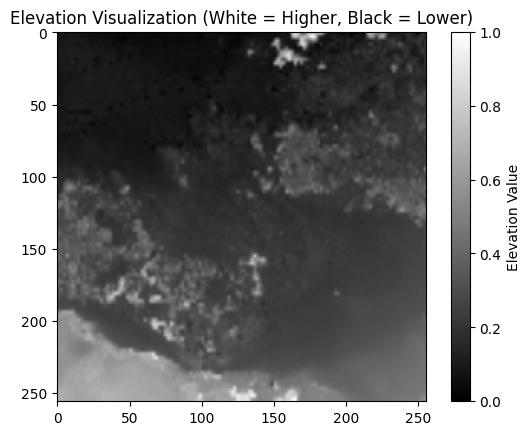

In [117]:
plt.imshow(landscape.elevation, cmap='gray')
plt.title('Elevation Visualization (White = Higher, Black = Lower)')
plt.colorbar(label='Elevation Value')
plt.show()